# Reading in data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../Data/deathrate_clean.csv')

# Linear regression model

Single county

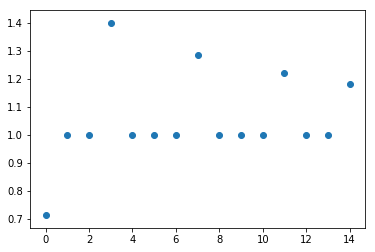

In [2]:
county_name = 'Alameda County, CA'
alameda = data[data['County'] == county_name]
alameda_y = alameda[alameda["Year"] >= 2000]['Deathrate']
alameda_x = alameda[alameda["Year"].isin(range(1999, 2014))]["Deathrate"]
alameda_X = np.diag(alameda_x)

from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept = False).fit(alameda_X, alameda_y)
plt.scatter(range(alameda_y.size), reg.coef_)
plt.show()

Multiple counties

In [3]:
max_counties = 3133
all_counties = data["County"].unique()
unique_counties = all_counties[:max_counties]

y_list = []
X_list = []

for county_name in unique_counties:
    county = data[data["County"] == county_name]
    county_y = county[county["Year"].isin(range(2000,2015))]["Deathrate"]
    county_x = county[county["Year"].isin(range(1999, 2014))]["Deathrate"]
    county_X = np.diag(county_x)
    y_list.append(county_y)
    X_list.append(county_X)
    
y = [element for county_y in y_list for element in county_y ]

from scipy.linalg import block_diag

X = block_diag(*X_list)

OLS solution

In [ ]:
beta_ols = y / np.diag(X)
beta_ols

Plot of coefficient vector

In [ ]:
plt.plot(range(len(y)), beta_ols)
plt.show()

Plot of sorted coefficient vector

In [ ]:
plt.plot(range(len(y)), np.sort(beta_ols))
plt.show()

Ridge regression solution with prior mean $\mu = \underline{1}$.

$$
\beta = (X^T X + \lambda I)^{-1} (X^T y + \lambda \underline{1}) =
\begin{pmatrix}
\frac{y_1 x_1 + \lambda}{x_1^2 + \lambda}\\
\vdots \\
\frac{y_n x_n + \lambda}{x_n^2 + \lambda}
\end{pmatrix}
$$

In [4]:
def ridge(y,X, llambda):
    x = np.diag(X) 
    return ((y * x + llambda)/(x**2 + llambda))

Compare solutions from OLS to solutions from ridge regression for various settings of $\lambda$.

In [5]:
def model_comparison(y, X, llambda, sort = False):
    reg_ols = ridge(y, X, 0)
    
    if sort: reg_ols = np.sort(reg_ols)
    plt.plot(reg_ols)
    
    reg_ridge = ridge(y, X, llambda)
    
    if sort: reg_ridge = np.sort(reg_ridge)
    plt.plot(reg_ridge)

    is_sorted = " (sorted)" if sort == True else ""
    plt.title("Comparison of OLS and Ridge regression coefficient vectors" + is_sorted )

    plt.legend(['OLS', 'Ridge with $\lambda=$' + str(llambda)])
    plt.show()

Comparison of methods for Alameda county.

In [ ]:
model_comparison(alameda_y, alameda_X, 100)

Comparison of methods for multiple counties.

In [ ]:
model_comparison(y,X,100)

In [ ]:
model_comparison(y,X, 100, sort = True)

Ridge regression with prior mean $\mu$ and prior covariance $\Sigma$.

$$\beta = (X^T X + \lambda \Sigma)^{-1} (X^T y + \lambda \Sigma \mu)$$

In [6]:
def ridge(y, X, llambda, mu = None, Sigma = None):
    
    x = np.diag(X) 
    
    if mu is None:
        mu = np.ones(len(y))
        
    if Sigma is None:
        return ((y*x + llambda * mu) / (x**2 + llambda))
    else:
        return np.linalg.solve((X.T@X) + (llambda*Sigma), (X.T@y) + llambda*(Sigma@mu))

Problem: Computing the exact solution may can be slow due to the matrix multiplication and inversion.

Question: Can we compute an acceptable approximation in less time using gradient descent?

Our loss function is given by

$$
L(\beta) = \|y - X\beta\|_2^2 + \lambda (\beta-\underline{1})^T \Sigma (\beta - \underline{1})
$$

The gradient of this function is

$$
\nabla L(\beta) = 2X^T (X\beta - y) + 2\lambda \Sigma (\beta - \underline{1}) = \begin{pmatrix}
2x_1 (x_1 \beta - y_1) + 2\lambda (\beta_1 - 1) \times \Sigma_{1,\cdot} \\
\vdots\\
2x_n(x_n \beta - y_n) + 2\lambda(\beta_1 - 1) \times \Sigma_{n,\cdot}
\end{pmatrix}
$$

Gradient descent update:

$$
\beta_{t+1} = \beta_{t} - \alpha \nabla L(\beta_t).
$$


In [7]:
def descent_update(y, X, alpha, beta, llambda, mu, Sigma):
    
    x = np.diag(X)
    gradient = 2* x**2 * beta - 2 * x * y
    
    penalty = np.zeros(len(beta))
    
# Method 1
#     for i in range(len(beta)):
#         for j in range(len(beta)):
#             penalty[i] = penalty[i] + (2*llambda * (beta[j] - mu[j]) * Sigma[i,j])

# Method 2
#    penalty = [2 * llambda * np.sum([row[j] * (beta[j] - mu[j]) for j in range(len(row))]) for row in Sigma]        

# Method 3
#    from scipy import sparse
#    penalty = 2 * llambda * sparse.csr_matrix(Sigma) @ (beta - mu)

# Method 4
    penalty = 2 * llambda * Sigma @ (beta - mu)
    
    gradient += penalty

    return np.array(beta - alpha * gradient)

Exploring fastest ways to implement the descent update above.

In [ ]:
alpha = 0.01
n = len(y)
beta = np.zeros(n)
llambda = 10
mu = np.ones(n)
Sigma = np.eye(n)

In [ ]:
%%time
beta1 = descent_update(y, X, alpha, beta, llambda, mu, Sigma)

Full gradient descent algorithm:

In [8]:
def GD(input_y, input_X, alpha, llambda, mu, Sigma, max_iter):

    beta_initial = np.zeros(len(input_y))
    beta = beta_initial
    
    for t in range(max_iter):
        beta = descent_update(input_y, input_X, alpha, beta, llambda, mu, Sigma)
    
    return beta

Comparison between gradient descent and the exact solution to get an idea of the step size and number of iterations needed to compute an acceptable approximation.

In [9]:
def GD_diagnostic(input_y, input_X, alpha, llambda, mu, Sigma, max_iter):

    reg_ridge = ridge(input_y, input_X, llambda)

    beta_initial = np.zeros(len(input_y))
    beta = beta_initial
    
    differences = np.zeros(max_iter)
    for t in range(max_iter):
        beta = descent_update(input_y, input_X, alpha, beta, llambda, mu, Sigma)
        differences[t] = np.linalg.norm(reg_ridge - beta)
        
    plt.plot(range(max_iter), differences)
    plt.title("Distance from exact solution versus number of iterations")
    plt.show()
    print('Distance from exact solution for last iteration is ' + str(differences[-1]))
    
    plt.plot(range(len(reg_ridge)), reg_ridge)
    plt.plot(range(len(reg_ridge)), beta)
    plt.title("Comparison of Ridge regression coefficient vectors and gradient descent")
    plt.legend(['Ridge with $\lambda = $' + str(llambda), 'Gradient descent with stepsize = ' + str(alpha)])
    # Note: Only a relevant comparison for Sigma = Identity. 
    # There is not closed form available for comparison when Sigma != Identity.
    # We want a sense of how many gradient iterations give us a similar answer to the exact solution.
    plt.show()

Test on single county case

In [ ]:
GD_diagnostic(alameda_y, alameda_X, alpha = 0.001, llambda = 100, mu = np.ones(15), Sigma = np.eye(15), max_iter = 20)

Multiple counties

In [ ]:
GD_diagnostic(y, X, alpha = 0.001, llambda = 100, mu = np.ones(len(y)), Sigma = np.eye(len(y)), max_iter = 50)

Gradient descent seems to produce an answer roughly equal to the exact solution after 20-30 iterations with step size equal to 0.001.

Gradient descent is consistently slower the computing the exact solution for the case $\mu = (1,\dots,1)$ and $\Sigma = I$. For more general $\Sigma$, we need to compute the normal equations. Fifty iterations of gradient descent produces a reasonable solution much faster than solving the linear system.

In [ ]:
n = len(y)
Z = np.random.randn(n)
Sigma = np.eye(n) + np.outer(Z,Z)

In [ ]:
%%time 

beta = GD(y, X, alpha = 0.001, llambda = 100, mu = np.ones(len(y)), Sigma = Sigma, max_iter = 50)

For 100 counties, the solving the linear system takes 55 seconds and gradient descent takes 420ms to reach 50 iterations.

For 500 counties, gradient descent takes 20s to reach 50 iterations.

For 1000 counties, gradient descent takes 1 min 18s to reach 50 iterations.

For all 3313 counties...my computer crashes.